In [1]:
"""
This test explains how to use kenkenpa using the simple chatbot example from LangGraph.
Some parts of the test code reuse the code listed at the following URL.
https://langchain-ai.github.io/langgraph/tutorials/introduction/
"""

'\nThis test explains how to use kenkenpa using the simple chatbot example from LangGraph.\nSome parts of the test code reuse the code listed at the following URL.\nhttps://langchain-ai.github.io/langgraph/tutorials/introduction/\n'

In [2]:
# We will define the chatbot function that will serve as the node.
# This follows the QuickStart guide.

from langchain_openai import ChatOpenAI

# LLM settings
llm = ChatOpenAI(
    model="gpt-4o-mini"
)

def chatbot(state,config):
    return {"messages":[llm.invoke(state["messages"])]}

# Apart from the chatbot,
# it is necessary to define a factory function that returns the defined chatbot.
def gen_chatbot_agent(factory_parameter,flow_parameter):
    """chatbot node factory"""
    return chatbot

In [3]:
# Define the structured data representing the StateGraph.
graph_settings = {
    "graph_type":"stategraph",
    "flow_parameter":{
        "name":"React-Agent",
        "state" : [
            {
                "field_name": "messages",
                "type": "list",
                "reducer":"add_messages"
            },
        ],
    },
    "flows": [
        { # This is the definition of the node chatbot.
            "graph_type":"node",
            "flow_parameter": {
                "name":"chatbot_agent",
                # Specify the string that maps to the factory function (gen_chatbot_agent) defined in the factory.
                # The mapping is specified at runtime.
                "factory":"chatbot_factory",
            },
        },
        { # normal_edge START-> chatbot_agent
            "graph_type":"edge",
            "flow_parameter":{
                "start_key":"START",
                "end_key":"chatbot_agent"
            },
        },
        { # normal_edge chatbot_agent-> END
            "graph_type":"edge",
            "flow_parameter": {
                "start_key":"chatbot_agent",
                "end_key":"END"
            },
        },
    ]
}

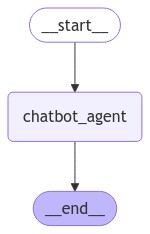

================================ Human Message =================================

Hi there! My name is Will.
================================== Ai Message ==================================

Hi Will! How can I assist you today?


In [4]:
from langgraph.graph import  add_messages
from langgraph.checkpoint.memory import MemorySaver

from kenkenpa.builder import StateGraphBuilder

# Generate the StateGraphBuilder from graph_settings.
stategraph_builder = StateGraphBuilder(graph_settings)

# Register the reducer with the StateGraphBuilder.
stategraph_builder.add_reducer("add_messages",add_messages)

# Register the node factory with the stategraph_builder.
# Here, we are mapping the gen_chatbot_agent function to "chatbot_factory".
# Please ensure it matches the key value listed in graph_settings.
stategraph_builder.add_node_factory("chatbot_factory",gen_chatbot_agent)

# You can obtain a compilable StateGraph using the gen_stategraph method.
stategraph = stategraph_builder.gen_stategraph()

# From here on, we will write the code following the general usage of LangGraph.
# Please note that this library does not involve config and checkpointer.
memory = MemorySaver()
app =  stategraph.compile(checkpointer=memory,debug=False)

from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

config = {"configurable": {"thread_id": "1"}}
user_input = "Hi there! My name is Will."
number_of_events = 0
events = app.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    number_of_events = number_of_events + 1
    event["messages"][-1].pretty_print()